In [3]:
# import
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import label, center_of_mass

In [4]:
# intialise all the important varibles
IRBT_THRESHOLD = 230  # IR Brightness Temperature threshold (K)
PIXEL_AREA_KM2 = 4.0  # Assuming 2km x 2km per pixel
MIN_AREA_KM2 = 5000 #34800  # Minimum area of TCC
MIN_RADIUS_KM = 100 #111   # Minimum radius of TCC

In [5]:
def load_irbt_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img.astype(np.float32)

def detect_tcc_mask(Tb):
    return Tb < IRBT_THRESHOLD

def extract_clusters(Tb, mask):
    labeled_mask, _ = label(mask)
    regions = measure.regionprops(labeled_mask, intensity_image=Tb)
    clusters = []

    for region in regions:
        area_km2 = region.area * PIXEL_AREA_KM2
        if area_km2 < MIN_AREA_KM2:
            continue

        cy, cx = region.centroid
        coords = region.coords
        center = np.array([cy, cx])
        distances = np.linalg.norm(coords - center, axis=1)
        max_radius = distances.max() * 2  # pixel-to-km scaling
        min_radius = distances.min() * 2
        mean_radius = distances.mean() * 2

        if max_radius < MIN_RADIUS_KM:
            continue

        Tb_values = Tb[coords[:, 0], coords[:, 1]]
        clusters.append({
            "center": (cx, cy),
            "pixel_count": region.area,
            "mean_Tb": Tb_values.mean(),
            "min_Tb": Tb_values.min(),
            "median_Tb": np.median(Tb_values),
            "std_Tb": Tb_values.std(),
            "max_radius": max_radius,
            "min_radius": min_radius,
            "mean_radius": mean_radius
        })

    return clusters

def estimate_cloud_top_height(Tb_value):
    return 17 - (Tb_value - 200) / 10

def add_height_metrics(clusters):
    for cluster in clusters:
        min_ht = estimate_cloud_top_height(cluster['min_Tb'])
        mean_ht = estimate_cloud_top_height(cluster['mean_Tb'])
        cluster['max_cloud_top_height'] = min_ht
        cluster['mean_cloud_top_height'] = mean_ht
    return clusters

def process_image(image_path):
    Tb = load_irbt_image(image_path)
    mask = detect_tcc_mask(Tb)
    clusters = extract_clusters(Tb, mask)
    clusters = add_height_metrics(clusters)
    for c in clusters:
        c['image'] = os.path.basename(image_path)
    visualize_clusters(Tb, mask, clusters, image_path)
    return clusters

def process_image_folder(folder_path):
    all_clusters = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".jpg"):
            path = os.path.join(folder_path, filename)
            print(f"Processing {filename}...")
            clusters = process_image(path)
            all_clusters.extend(clusters)
    return pd.DataFrame(all_clusters)

In [6]:
def visualize_clusters(Tb, mask, clusters, image_path):
    plt.figure(figsize=(10, 5))

    #left img -> orginal gray
    plt.subplot(1, 2, 1)
    plt.imshow(Tb, cmap='gray')
    plt.title('Original IRBT Image')
    plt.axis('off')

    #right img -> after implementations
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='Blues')
    for cluster in clusters:
        x, y = cluster['center']
        plt.plot(x, y, 'ro')
    plt.title('Detected TCCs with Centers')
    plt.axis('off')

    plt.suptitle(f"Visualization for {os.path.basename(image_path)}")
    plt.tight_layout()
    plt.show()

Processing 20251770550_GOES19-ABI-mex-Sandwich-250x250.jpg...


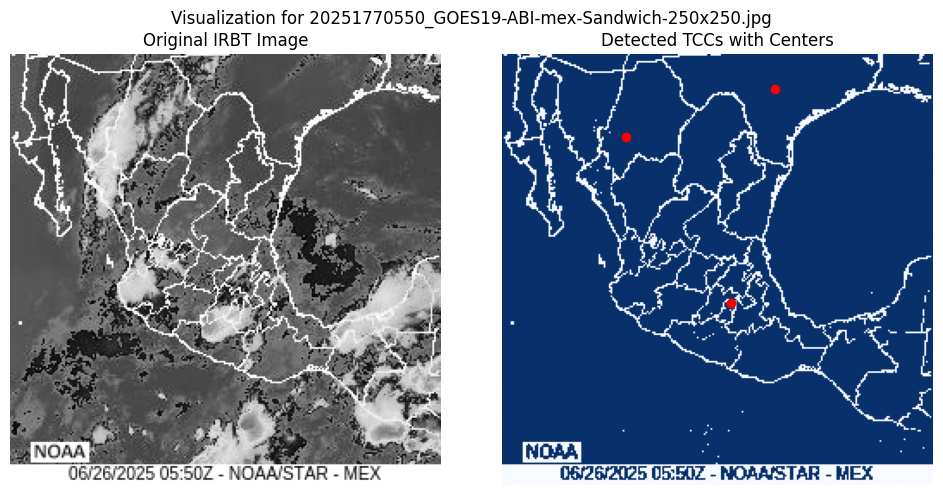

Processing 20251770600_GOES19-ABI-mex-Sandwich-250x250.jpg...


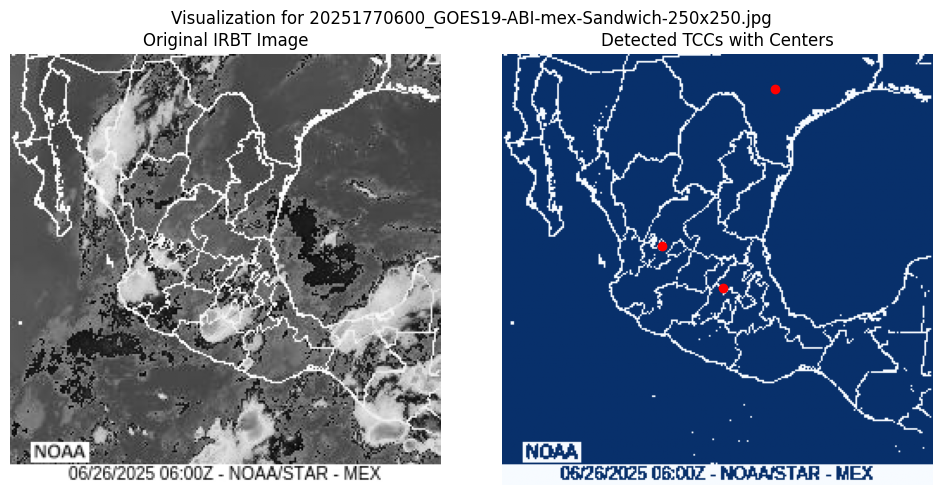

Processing 20251770610_GOES19-ABI-mex-Sandwich-250x250.jpg...


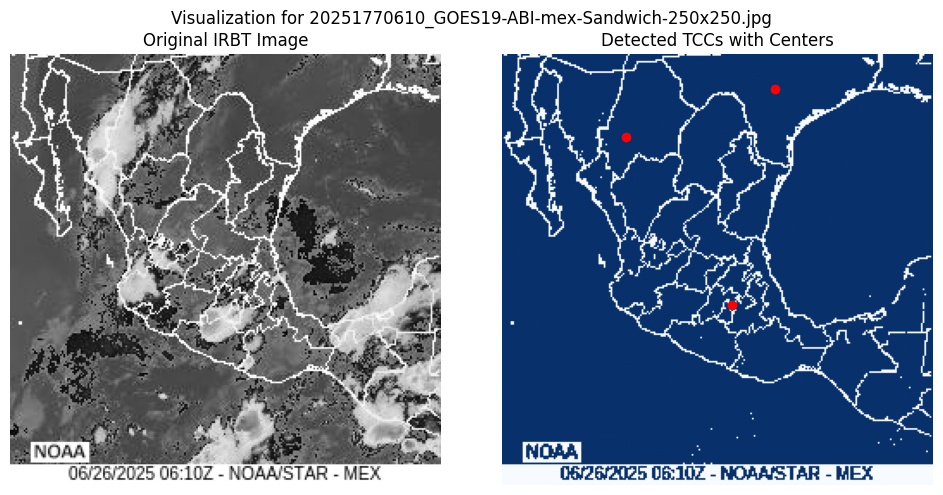

Processing 20251770620_GOES19-ABI-mex-Sandwich-250x250.jpg...


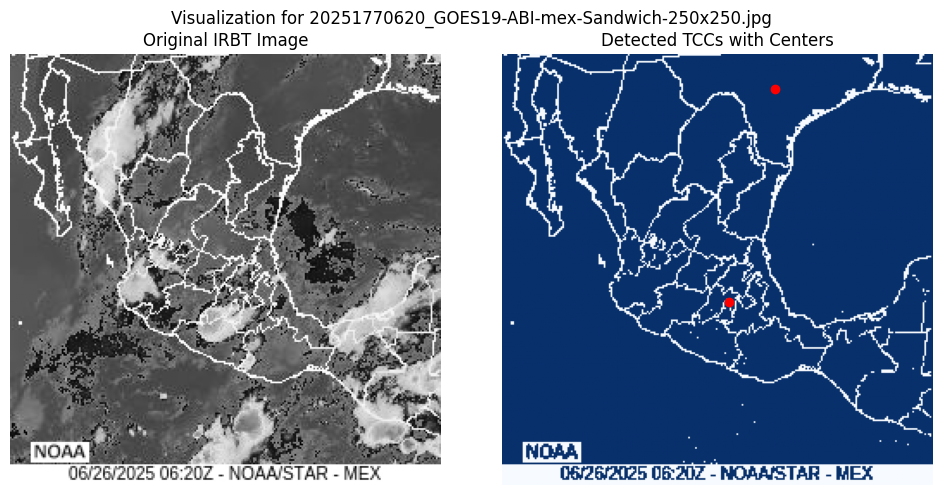

Processing 20251770630_GOES19-ABI-mex-Sandwich-250x250.jpg...


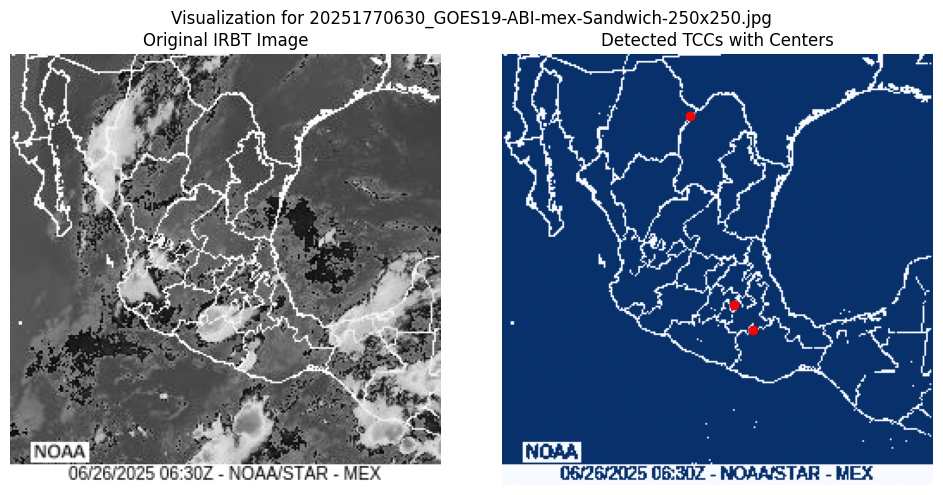

Processing 20251770640_GOES19-ABI-mex-Sandwich-250x250.jpg...


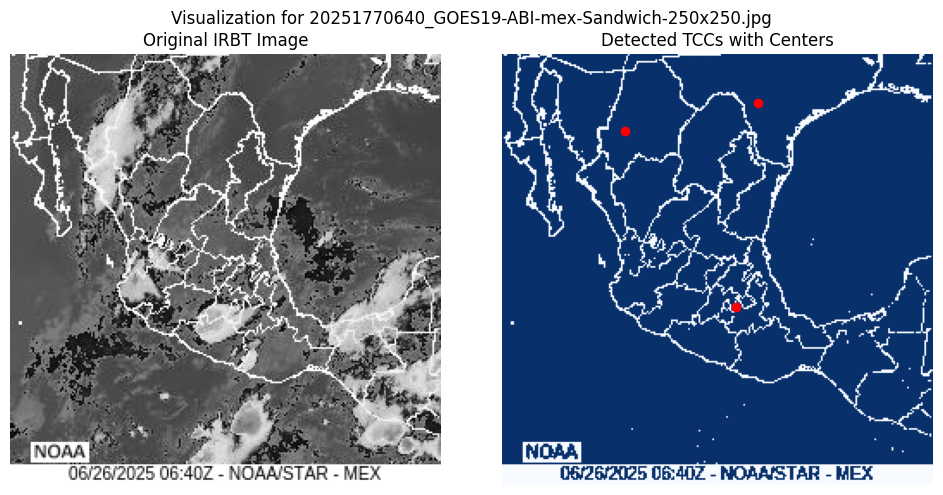

Processing 20251770650_GOES19-ABI-mex-Sandwich-250x250.jpg...


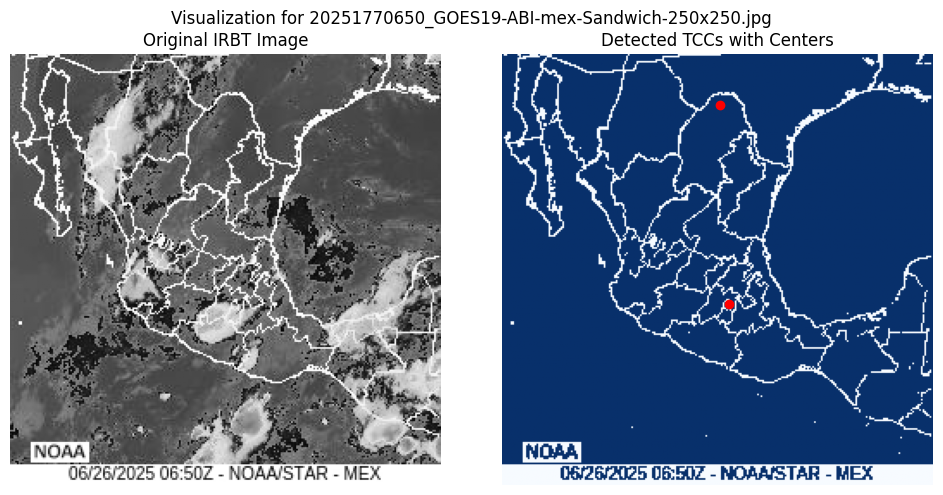

Processing 20251770700_GOES19-ABI-mex-Sandwich-250x250.jpg...


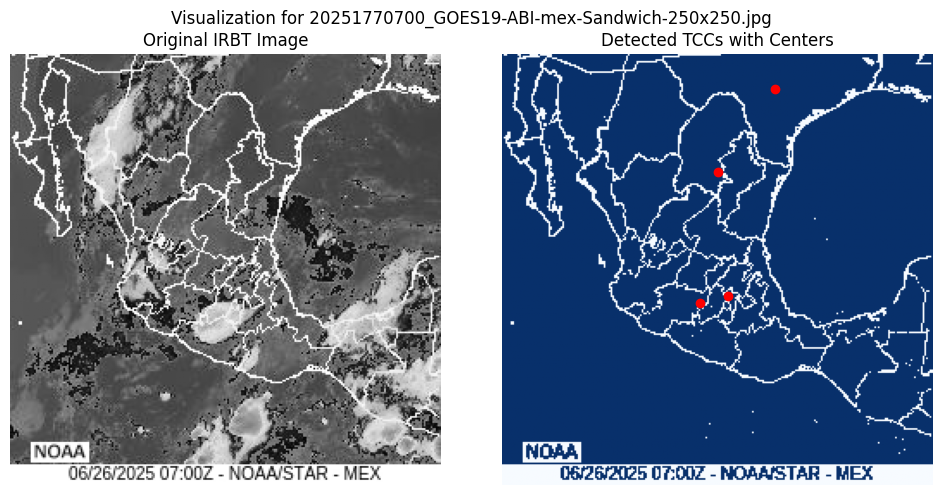

Processing 20251770710_GOES19-ABI-mex-Sandwich-250x250.jpg...


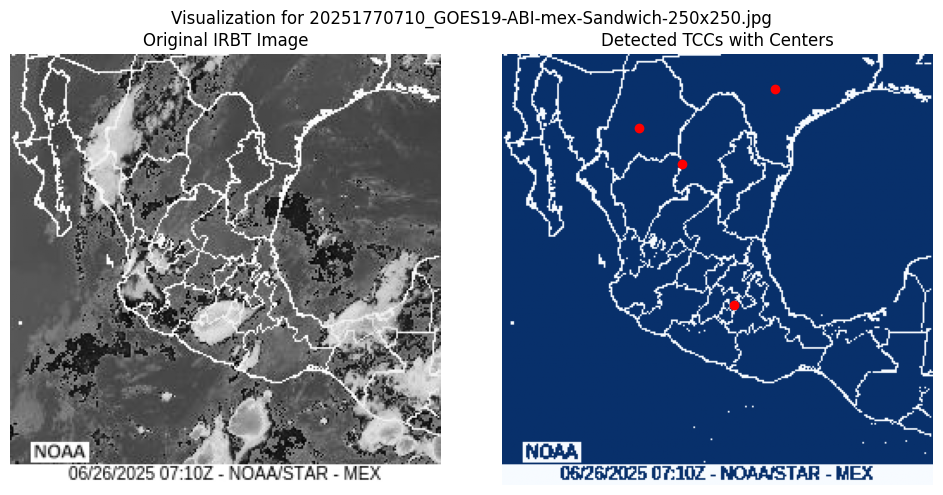

Processing 20251770720_GOES19-ABI-mex-Sandwich-250x250.jpg...


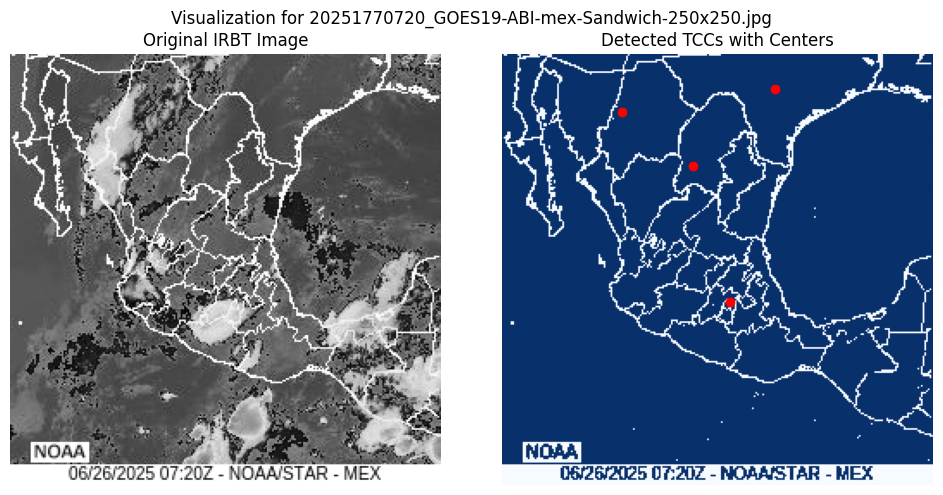

Processing 20251770730_GOES19-ABI-mex-Sandwich-250x250.jpg...


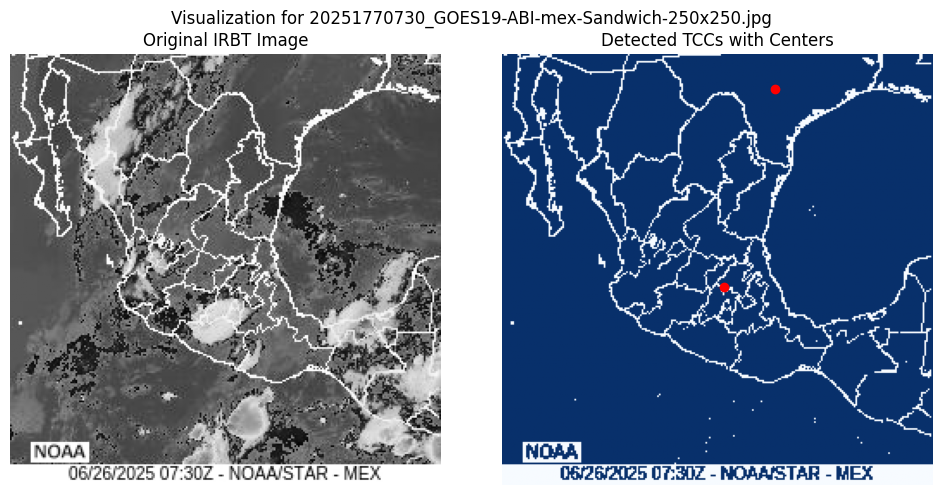

Processing 20251770740_GOES19-ABI-mex-Sandwich-250x250.jpg...


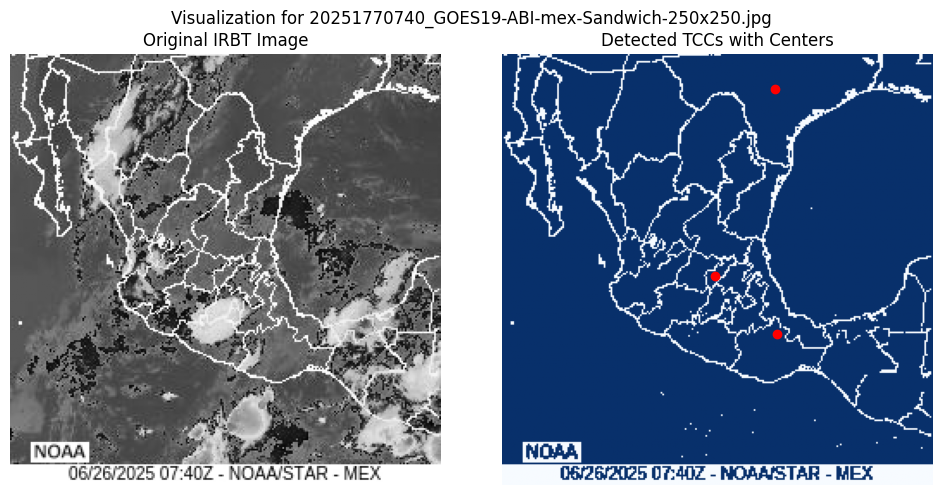

Processing 20251770750_GOES19-ABI-mex-Sandwich-250x250.jpg...


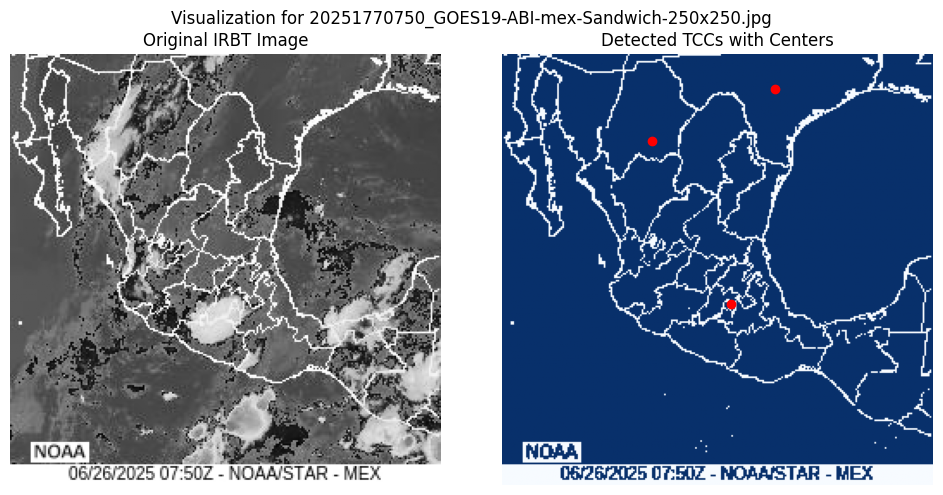

Processing 20251770800_GOES19-ABI-mex-Sandwich-250x250.jpg...


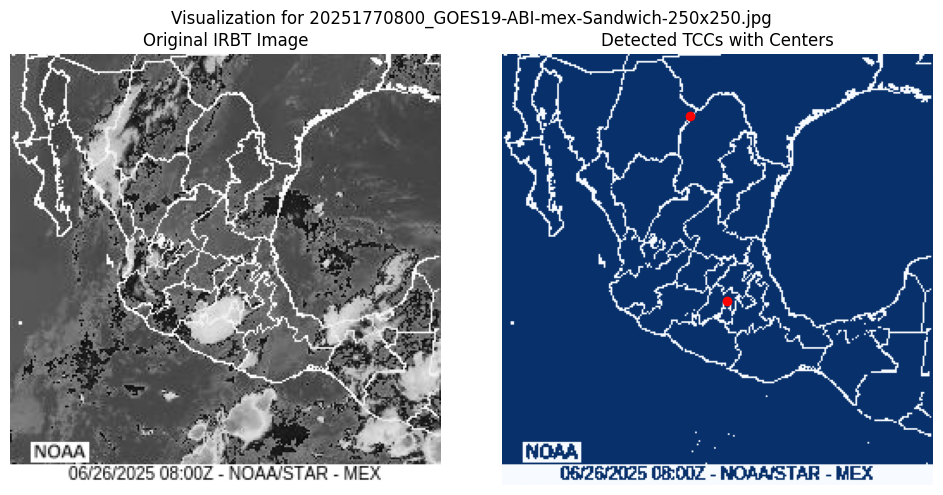

Processing 20251770810_GOES19-ABI-mex-Sandwich-250x250.jpg...


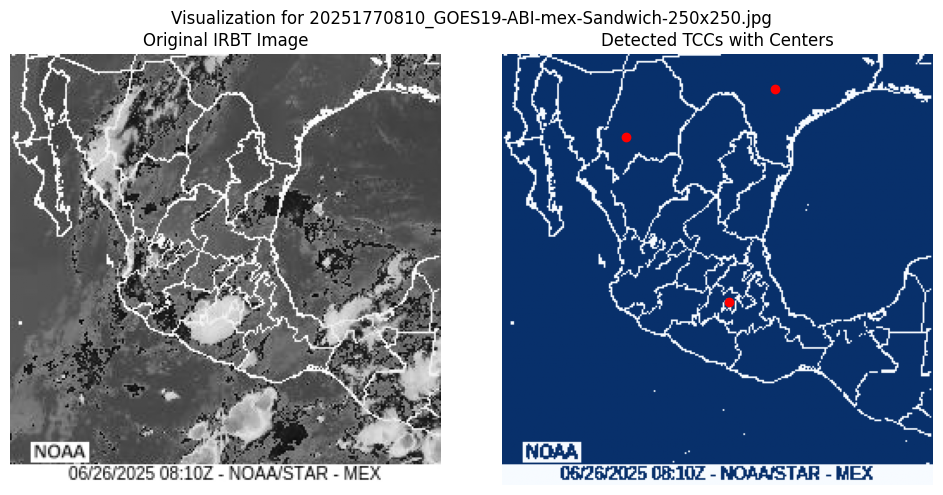

Processing 20251770830_GOES19-ABI-mex-Sandwich-250x250.jpg...


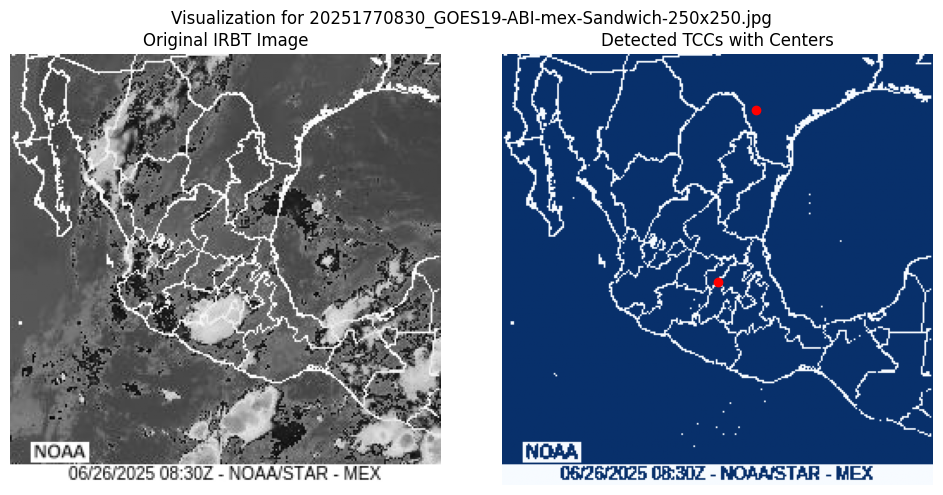

Processing 20251770840_GOES19-ABI-mex-Sandwich-250x250.jpg...


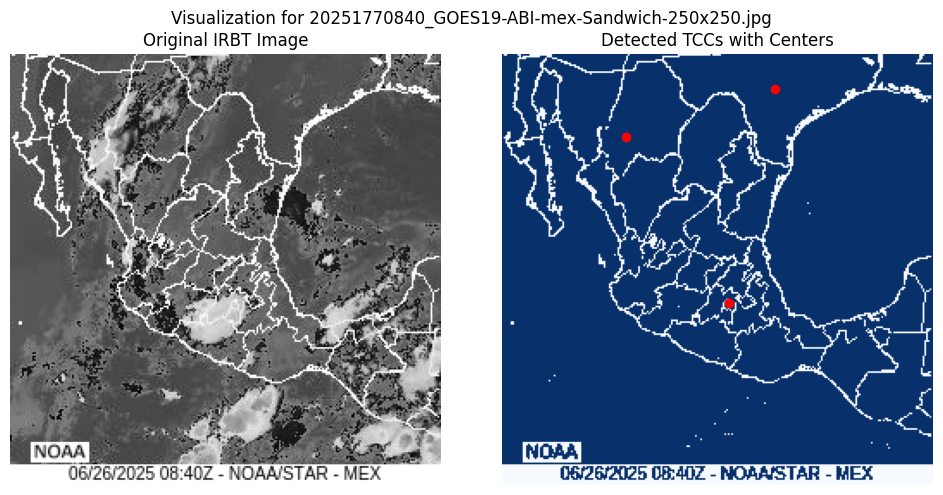

Processing 20251770850_GOES19-ABI-mex-Sandwich-250x250.jpg...


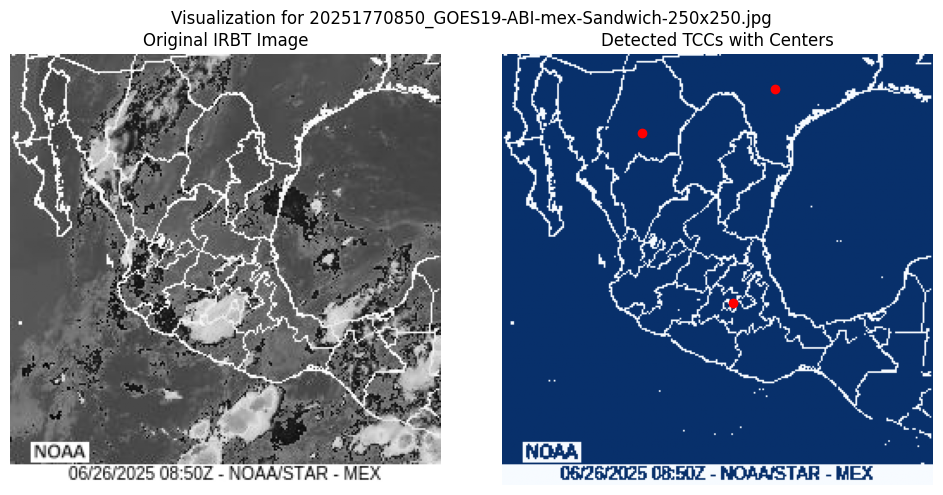

Processing 20251770900_GOES19-ABI-mex-Sandwich-250x250.jpg...


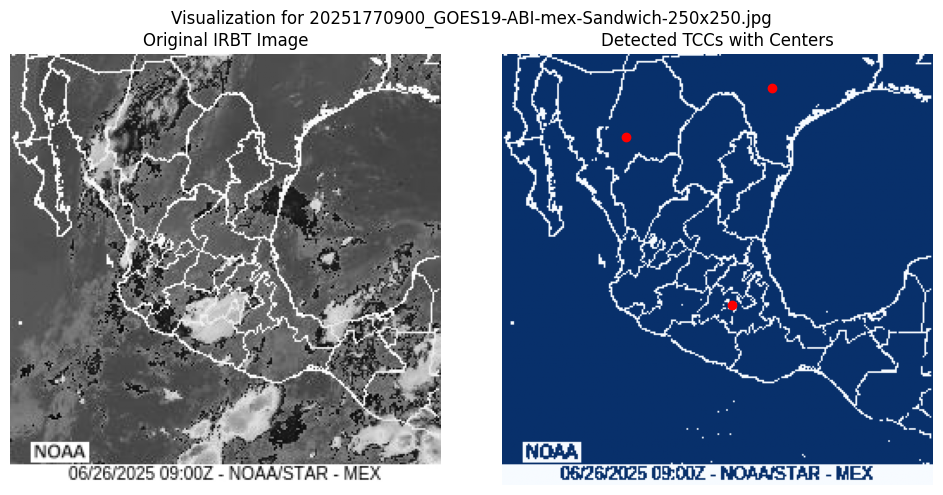

Processing 20251770910_GOES19-ABI-mex-Sandwich-250x250.jpg...


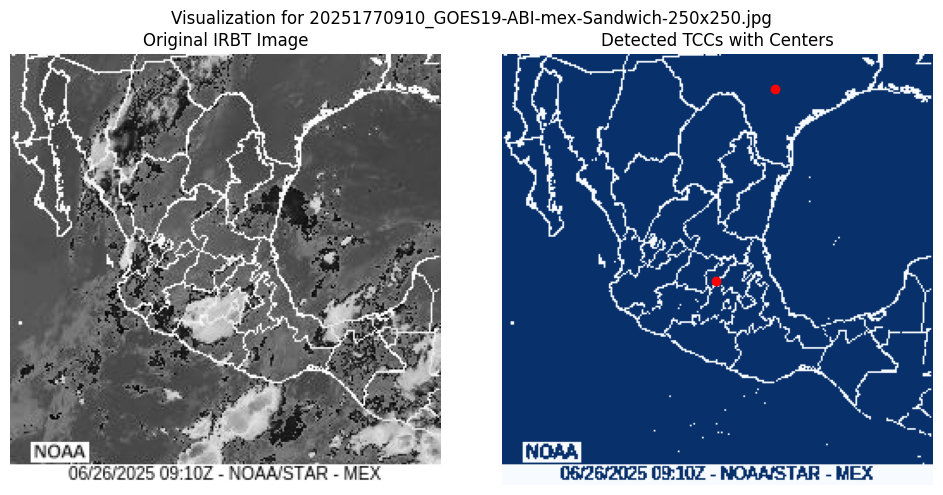

Saved output to tcc_features.csv


In [10]:
# final function calls
data_folder = 'dataset/Dataset'
df = process_image_folder(data_folder)
df['label'] = ((df['min_Tb'] < 210) & (df['max_radius'] > 60)).astype(int)
# CSV
df.to_csv("tcc_features.csv", index=False)
print("Saved output to tcc_features.csv")


In [9]:
#RANDOM FOREST CLASSIFIER (supervised ML) 
#feature extraction, these features as input
#labels are for severity as outputs
features = ['min_Tb', 'mean_Tb', 'median_Tb', 'std_Tb', 'mean_radius', 'max_radius', 'pixel_count']
X = df[features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


NameError: name 'train_test_split' is not defined

DONE